# <center> PHY68 Project 3: The Ising Model </center>
### <center> By [Name Ommitted], [Name Ommitted], and Daniel Opara </center>
### <center> March 17, 2023 </center>

We explore the use of random algorithms via Monte Carlo numerical methods. In this project, we sought out to implement the Ising Model using the Metropolis algorithm to observe the emergence of ferromagnetism in some metals. Although the code below shows an implemented version of the Metropolis algorithm, there are a few other Monte Carlo based numerical methods that could have been used to simulate emergence of ferromagnetism. Below, we go over the pros and cons of each of these algorithms and why exactly we settled on the Metropolis algorithm.

### <center> Metropolish-Hastings Algorithm </center>
<center> 

| Pros      | Cons |
| ----------- | ----------- |
| Easy to implement, and can be used to sample from complex distributions. | This implementation is very sensitive to the distribution, and if the proposal distribution is chosen incorrectly the algorithm may not produce an ideal output |
| It is very flexible given that you can obtain samples from distributions that have multiple modes   | Sensitive to the size step  |
| Not required to know what the shape of our object is | |

</center> 

### <center> Swendsen-Wang Algorithm </center>
<center> 

| Pros      | Cons |
| ----------- | ----------- |
| The algorithm is rejection free. This means that flipping the signs of one cluster of electrons in the lattice can be done independently of any knowledge about other electrons in the lattice. | Changes in the cluster(s) may not conserve number of particles if we’re using a gas interpretation |
| In large systems, we can run into issues with critical slowing down, which will make computations take a long time. The Swendsen-Wang algorithm avoids critical slowing down and performs very well with larger counts of electrons. | There are other algorithms, such as the Wolff algorithm, which avoid critical slowing down even more than the Swendsen-Wang algorithm |


</center> 

### <center> Wolff Algorithm </center>
<center> 

| Pros      | Cons |
| ----------- | ----------- |
| Simple to implement | Changes in the cluster(s) may not conserve number of particles if we’re using a gas interpretation |
| Avoids critical slowing down well, and thus makes itself very useful with a large count of electrons | Algorithm is rejection free, which means that flipping the signs of one cluster of electrons in the lattice can be done independently of any knowledge about other electrons in the lattice. |


</center> 

In the end, we decided to implement the Metropolis algorithm because it was what we were most familiar with and it seemed simple to implement. 

In [47]:
# import necessary packages
import random
import numpy as np
from numba import prange
from matplotlib import pyplot as plt
from matplotlib import colors

In [48]:
#Initialize array where all values are -1 or 1 with given dimensions
def initialize_2d(size):
  """
  Given an integer n, a lattice of size n by n will be generated with random
  values -1 or 1 at each index
  """
  return np.random.choice(np.array([-1,1]),size=(size,size))

def initialize_1d(size):
  """
  Given an integer n, a lattice of length n will be generated with random
  values -1 or 1 at each index
  """
  energy_choice = (-1,1)
  lattice = [random.choice(energy_choice) for i in range(0, size)]
  return lattice

### Calculating Lattice Energy
Here, we will write a function to calculate the energy of any given state by totaling up the energy of each index's neighbor. Similar to the functions we have to initialize a lattice, we have seperate functions to calculate the energy of 2D lattice and a 1D lattice.

In [49]:
def get_energy_2d(lattice):
  dimensions = lattice.shape[0]
  #initialize energy to zero
  energy = 0
  
  #prange allows for loops to run in parallel
  for i in prange(dimensions):
    for j in prange(dimensions):

      neighbor_energy = lattice[(i-1)%dimensions, j] + lattice[(i+1)%dimensions, j] + lattice[i, (j-1)%dimensions] + lattice[i, (j+1)%dimensions]
      energy -= lattice[i,j] * neighbor_energy

  # we divide by two to avoid double counting
  return energy / 2

def get_energy_1d(lattice):
  arr_len = len(lattice)
  #initialize energy to zero
  energy = 0
  
  #prange allows for loops to run in parallel
  for i in prange(arr_len):
    if i == 0:
      neighbor_energy = lattice[0] + lattice[i + 1]
    elif i == arr_len - 1:
      neighbor_energy = lattice[i - 1] + lattice[arr_len - 1]
    else:
      neighbor_energy = lattice[i - 1] + lattice[i + 1]
    energy -= lattice[i] * neighbor_energy

  # we divide by two to avoid double counting
  return energy / 2

We define a function to print out one dimensional lattices to make visualizing them easier

In [71]:
def plot_1D_lattice(lattice, plot_name):
  arr_len = len(lattice)
  original_len = arr_len
  while (np.sqrt(arr_len) % 1 != 0):
    arr_len+=1
  dimensions = int(np.sqrt(arr_len))
  #create RGB array that we will fill in
  rgb = np.ones((dimensions, dimensions, 3)) #start with an array of white

  # used for adding number annotations and looping through the lattice
  integers = np.arange(arr_len).reshape(dimensions,dimensions)
  
  for (i, j), z in np.ndenumerate(integers):
    if z == original_len:
      break
    if lattice[z] == -1:
      rgb[i,j]=[0,0,255]
    elif lattice[z] == 1:
      rgb[i,j]=[255,0,0] 
    else:
      rgb[i,j]=[0,0,0] 
  plt.figure(figsize=(10,10))
  plt.imshow(rgb)


  # add number annotations
  integers = np.arange(arr_len).reshape(dimensions,dimensions)

  #add annotations based on: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
  for (i, j), z in np.ndenumerate(integers):
    if z == original_len:
      break
    plt.text(j, i, '{:d}'.format(z), ha='center', va='center',color='k',fontsize=15)

  # remove axis and tick labels
  plt.axis('off')
  plt.title(plot_name)
  plt.show()

## Metropolis Algorithm
This function runs the Metropolis algorithm, and flips the spin of a lattice until its energy is approximately equal to the temperature parameter that is given to the function. Like the other functions above, there are functions built to perform the algorithm for 1D and 2D lattices, respectively. 

Running the Metropolis algorithm given a specific temperature and the number of steps to run returns the modified lattice along with its current energy level and magnetization. It must be noted that, with each function, they come with a helper function to calculate the magnetization of a lattice at each step in the program.

In [51]:
def get_magnetization_1d(lattice):
  arr_len = len(lattice)
  #initialize magnetization to zero
  mz = 0
  
  #prange allows for loops to run in parallel
  for i in prange(arr_len):
      mz += lattice[i]

  # we then normalize by the lattice size
  return mz / arr_len**2

def metropolis_1d(lattice_og, lattice_result, step_count, temp):
  
  curr_lattice = lattice_result
  arr_len = len(lattice_og)
  energy_per_step = []
  mag_per_step = []

  for n in range(0, step_count):
    #original distance from temp 
    abs1 = abs(get_energy_1d(curr_lattice) - temp)

    #choose random position in array
    i = np.random.randint(arr_len)
    #flip the spin of our copy
    curr_lattice[i] = -1 * curr_lattice[i]

    #set beta to temperature times Boltzmann constant
    k = 1
    beta = 1/(temp*k)

    #generate random number to be compared to -e^beta
    random_num = np.random.random()


    #new distance from temp
    curr_energy = get_energy_1d(curr_lattice)
    abs2 = abs(curr_energy - temp)


    if ((abs1 > abs2) or (random_num < -1* np.exp(beta))):
      #accept the change
      continue
    else:
      curr_lattice[i] = -1 * curr_lattice[i]
      curr_energy = get_energy_1d(curr_lattice)
 
    energy_per_step.append(curr_energy)
    mag_per_step.append(get_magnetization_1d(curr_lattice))
  results = {
    "energy_per_step": energy_per_step,
    "lattice_results": curr_lattice,
    "mag_per_step": mag_per_step
  }
  return results

In [52]:
def get_magnetization_2d(lattice):
  dimensions = lattice.shape[0]
  #initialize magnetization to zero
  mz = 0
  
  #prange allows for loops to run in parallel
  for i in prange(dimensions):
    for j in prange(dimensions):

      mz += lattice[i,j]

  # we then normalize by the lattice size
  return mz / dimensions**2

def metropolis_2d(lattice_og, lattice_result, step_count, temp):

  curr_lattice = lattice_result
  dimensions = lattice_og.shape[0]
  energy_per_step = []
  mag_per_step = []

  for n in range(0, step_count):
    #original distance from temp 
    abs1 = abs(get_energy_2d(curr_lattice) - temp)

    #choose random position in array
    i, j = np.random.randint(dimensions), np.random.randint(dimensions)
    #flip the spin of our copy
    curr_lattice[i,j] = -1 * curr_lattice[i,j]

    #set beta to temperature times Boltzmann constant
    k = 1
    beta = 1/(temp*k)

    #generate random number to be compared to -e^beta
    random_num = np.random.random()


    #new distance from temp
    curr_energy = get_energy_2d(curr_lattice)
    abs2 = abs(curr_energy - temp)


    if ((abs1 > abs2) or (random_num < -1* np.exp(beta))):
      #accept the change
      continue
    else:
      curr_lattice[i,j] = -1 * curr_lattice[i,j]
      curr_energy = get_energy_2d(curr_lattice)
 
    energy_per_step.append(curr_energy)
    mag_per_step.append(get_magnetization_2d(curr_lattice))
  results = {
    "energy_per_step": energy_per_step,
    "lattice_results": curr_lattice,
    'mag_per_step': mag_per_step
  }
  return results

We can observe the change the the energy levels and the lattice itself by plotting the lattice and its respective energy level before and after undergoing the Metropolis algoritm

In [ ]:
# We first observe how our algorith works with a 2D lattice
# Running this with the current settings took about 51 minutes
lattice = initialize_2d(300)
results = metropolis_2d(lattice, lattice.copy(), 10000, 100)

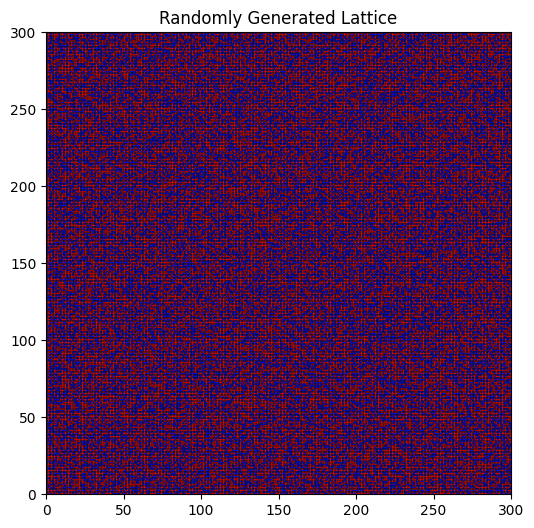

In [65]:
cmap = colors.ListedColormap(['Blue','red'])
plt.figure(figsize=(6,6))
plt.pcolor(lattice,cmap=cmap,edgecolors='k', linewidths=0.25)
plt.title('Randomly Generated Lattice')
plt.show()

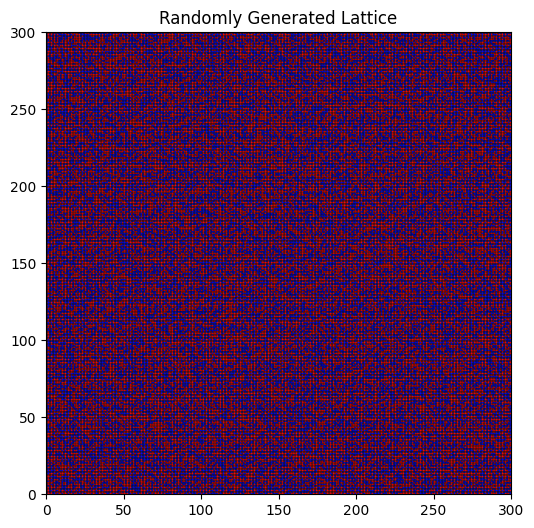

In [62]:
cmap = colors.ListedColormap(['Blue','red'])
plt.figure(figsize=(6,6))
plt.pcolor(results['lattice_results'],cmap=cmap,edgecolors='k', linewidths=0.25)
plt.title('Lattice After Flipping')
plt.show()

The energy for the lattice before algorithm is -612.0
The energy for the lattice after  algorithm is 100.0


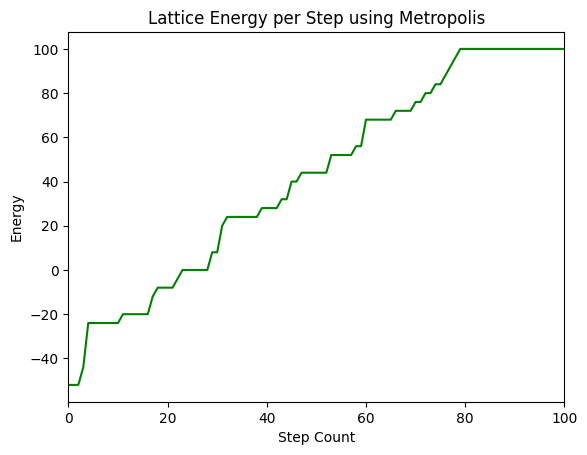

In [54]:
print("The energy for the lattice before algorithm is", get_energy_2d(lattice))
print("The energy for the lattice after  algorithm is", get_energy_2d(results["lattice_results"]))

energy = results['energy_per_step']
steps = np.arange(len(energy))
# plotting
plt.title("Lattice Energy per Step using Metropolis")
plt.xlabel("Step Count")
plt.ylabel("Energy")
plt.xlim(0,100)
plt.plot(steps, energy, color="green")
plt.show()

Surprisingly enough, the 2D lattice stabilized after about 80 steps. Next, we will run the same algorithm on a 1D lattice.

In [75]:
lattice_1d = initialize_1d(100)
results = metropolis_1d(lattice_1d, lattice_1d.copy(), 10000, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


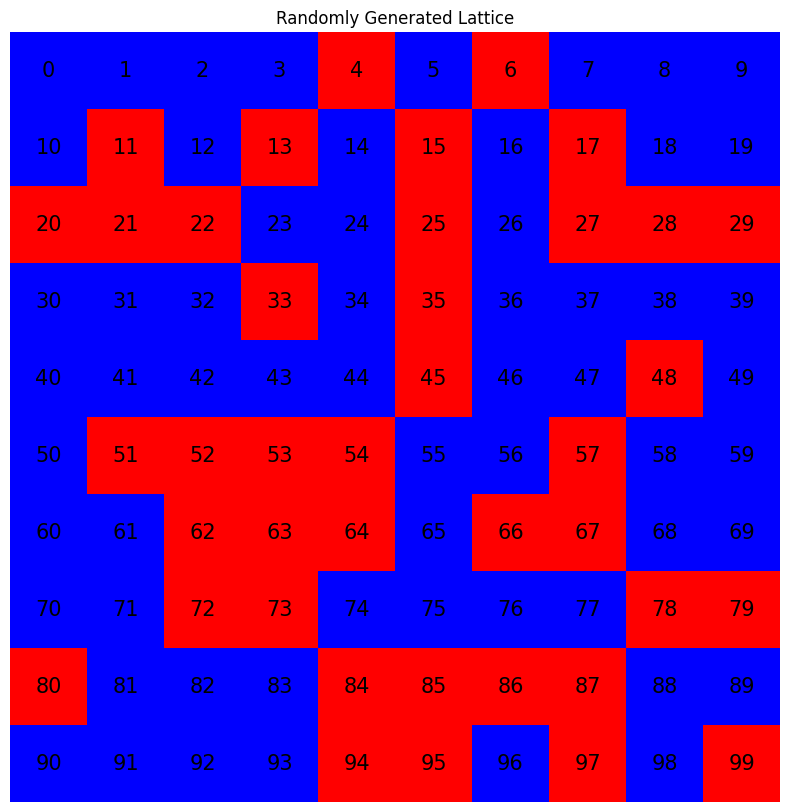

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


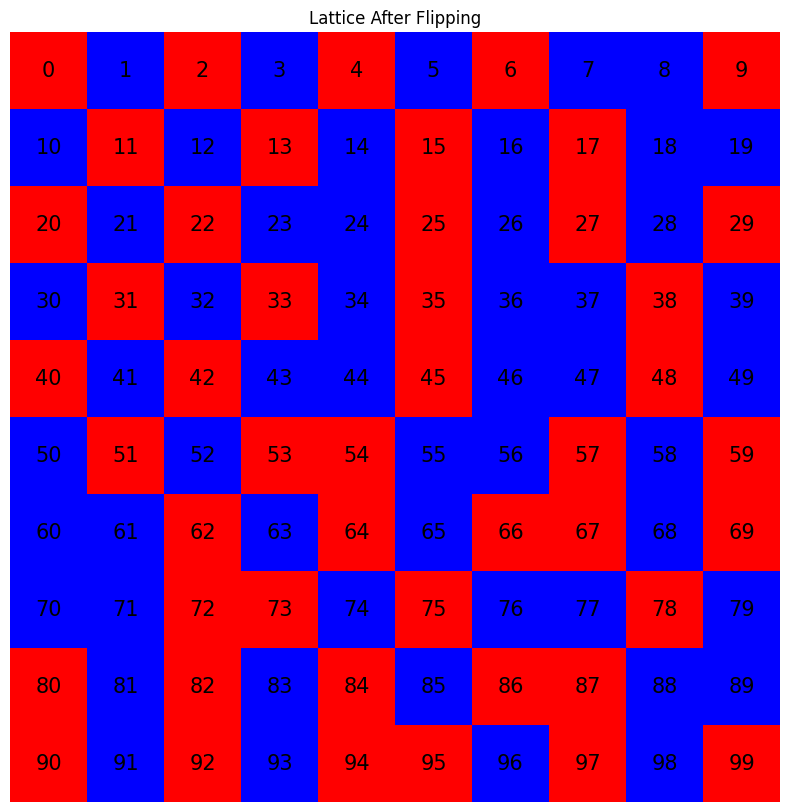

In [76]:
plot_1D_lattice(lattice_1d, "Randomly Generated Lattice")
plot_1D_lattice(results['lattice_results'], "Lattice After Flipping")

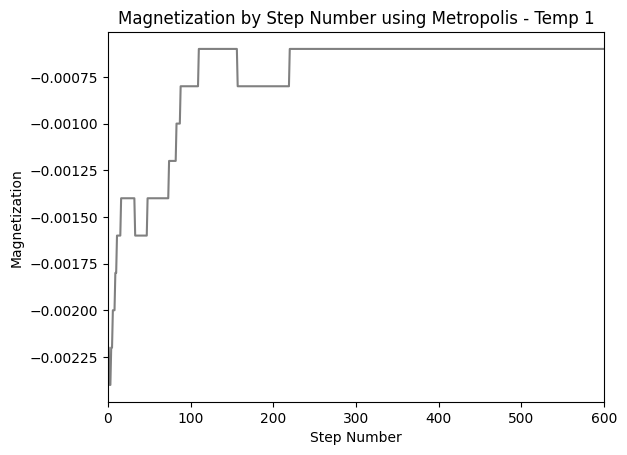

In [96]:
#plot magnetization of the 1D lattice
magnetization = results['mag_per_step']
steps = np.arange(len(magnetization))
# plotting
plt.title("Magnetization by Step Number using Metropolis - Temp 1")
plt.xlabel("Step Number")
plt.ylabel("Magnetization")
plt.xlim([0, 600])
plt.plot(steps, magnetization, color ="gray", label="Sample Line")
plt.show()

As we can see here, the one dimensional lattice, after undergoing the Metropolis algorithm, converges towards a magnitization value of zero. This serves as a good sanity check as to whether or not our implmentation of the Metropolis algorith is correct since 1D lattices should not show any emergence in ferromagnitism.

## Magnetization
When attempting to equilibrate a system that focuses on magnetization simulation, we look at the factor of spin. We plot magnetization per site. This would be the sum of spins. Here is the magnetization over step count of a lattice at temperature 100.

We need to perform a sufficient number of iterations to ensure that the system has reached equilibrium before collecting data. One way to determine the equilibration time is to monitor the magnetization as a function of time and check when it reaches a steady state. This can be done by plotting the magnetization as a function of simulation time and visually inspecting the plot to see when the magnetization stabilizes.

Another approach is to use an autocorrelation function to analyze the time correlation of the magnetization. This involves calculating the correlation between the magnetization at different points in time and examining how quickly the correlation decays to zero. When the correlation decays to zero, the system is considered to have reached equilibrium.

The specific number of iterations required to equilibrate a magnetization simulation at a given temperature can vary, but a good rule of thumb is to perform at least 10 times the relaxation time of the system. The relaxation time is a measure of the time it takes for the system to reach equilibrium and can be estimated from the autocorrelation function. Our results show that as the absolute value of temperature increases, the time it takes to equilibrate the system also increases. Below are two plots that show this phenomenon, with the vertical bar being the step number at which the magnetization stabilized.


In [55]:
# This will give us magnetization of a lattice after ungergoing the algorithm
def run_metropolis_magnetization(lattice_size, steps, temp):
  test = initialize_2d(lattice_size)
  results = metropolis_2d(test, test.copy(), steps, temp)
  return results['mag_per_step']

In [56]:
# This helper function will be useful for finding the point at which magnetization stabilizes
def find_stabilization_point(array, index, index_val):
  if array[index] != index_val:
    return index
  else: 
    return find_stabilization_point(array, index - 1, array[index])

In [57]:
temp_10 = run_metropolis_magnetization(20,200,10)
temp_50 = run_metropolis_magnetization(20,200,50)
temp_100 = run_metropolis_magnetization(20,200,100)

temp_n10 = run_metropolis_magnetization(20,200,-10)
temp_n50 = run_metropolis_magnetization(20,200,-50)
temp_n100 = run_metropolis_magnetization(20,200,-100)

temp_list_positive = [temp_10, temp_50, temp_100]
temp_list_negative = [temp_n10, temp_n50, temp_n100]

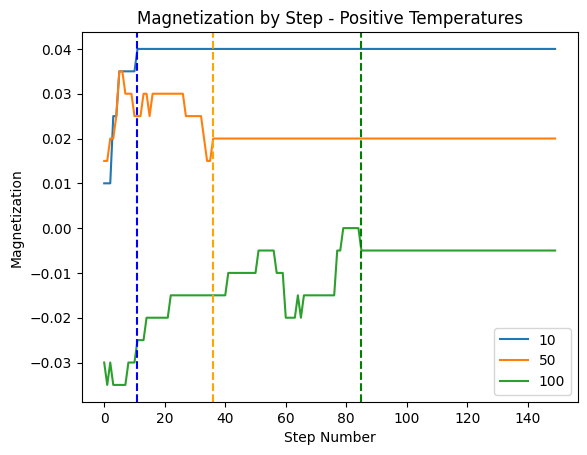

In [58]:
steps = np.arange(150)
temps = [10,50,100]
counter = 0
for temp in temp_list_positive:
  
  plt.plot(steps, temp[:150], label = str(temps[counter]))
  counter +=1

plt.legend(loc='best')
plt.title('Magnetization by Step - Positive Temperatures')
plt.xlabel('Step Number')
plt.ylabel('Magnetization')
plt.axvline(find_stabilization_point(temp_100[:150], len(temp_100[:150])- 1,
                                     temp_100[len(temp_100[:150]) - 1]) + 1, color = 'green', linestyle="dashed")
plt.axvline(find_stabilization_point(temp_50[:150], len(temp_50[:150])- 1,
                                     temp_50[len(temp_50[:150]) - 1]) + 1, color = 'orange', linestyle="dashed")
plt.axvline(find_stabilization_point(temp_10[:150], len(temp_10[:150])- 1,
                                     temp_10[len(temp_10[:150]) - 1]) + 1, color = 'blue', linestyle="dashed")

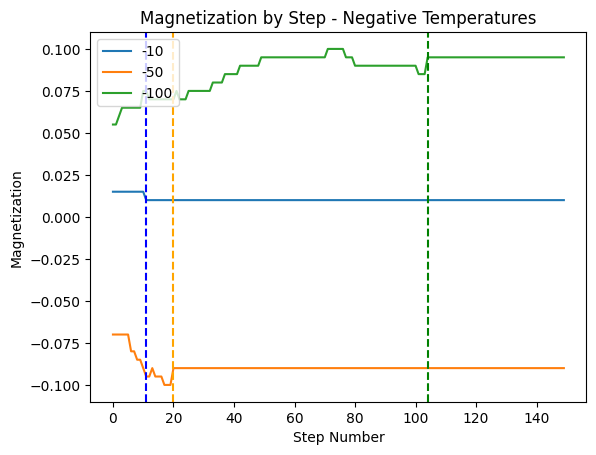

In [98]:
steps = np.arange(150)
temps = [-10,-50,-100]
counter = 0
for temp in temp_list_negative:
  
  plt.plot(steps, temp[:150], label = str(temps[counter]))
  counter +=1

plt.legend(loc='best')
plt.title('Magnetization by Step - Negative Temperatures')
plt.xlabel('Step Number')
plt.ylabel('Magnetization')

plt.axvline(find_stabilization_point(temp_n100[:150], len(temp_n100[:150])- 1,
                                     temp_n100[len(temp_n100[:150]) - 1]) + 1, color = 'green', linestyle="dashed")
plt.axvline(find_stabilization_point(temp_n50[:150], len(temp_n50[:150])- 1,
                                     temp_n50[len(temp_n50[:150]) - 1]) + 1, color = 'orange', linestyle="dashed")
plt.axvline(find_stabilization_point(temp_n10[:150], len(temp_n10[:150])- 1,
                                     temp_n10[len(temp_n10[:150]) - 1]) + 1, color = 'blue', linestyle="dashed")

In summary, the number of iterations required to equilibrate a magnetization simulation depends on the specific details of the system and the simulation parameters. A good approach is to monitor the magnetization as a function of time and use autocorrelation analysis to estimate the equilibration time, and perform at least 10 times this time to ensure that the system has reached equilibrium before collecting data.


# Estimating Random Numbers

Our code requires the generation of $n^2 + 2s$ random numbers, where $n$ is the dimension of the 2D array we generate and $s$ is the step count. This is because we first generate $n^2$ values in the initialization of our array, where we have to choose between -1 and 1 for the spins. We then must iterate through the 2D array and decide whether or not to flip the spin, which we do $s$ times. Each iteration requires the generation of two random numbers, meaning that we must generate $2s$ random numbers

Suppose we have a 100x100 lattice, and we want to perform the metropolis algorithm 20000 times. This is one of the most computationally intensive setups we tried, with the time this took approaching 14 minutes. This means we will generate $2500 + 40000 = 42500$ random numbers, plugging $n$ in as 50 and 20000 in as step count. This falls below the period of the Mersenne twister ($2^{19937} – 1$) but above the period of the C's random number generator (32767). This means that if we use our algorithm and generate random numbers using the C random number generator, we will have random number repetition.

## Further Exploration: Magnetization by Temperature
We wanted to further explore the relationship between magnetization and temperature. To do this, we ran our metropolis on a 20x20 lattice for 500 steps at temperatures ranging from 1 to 500 and found the magnetization of the resulting lattice. We then plotted it against the temperature, and obtained the following graph.

In [99]:
magnetizations = []
for i in range(1, 1000, 10):
  test3 = initialize_2d(20)
  results3 = metropolis_2d(test3, test3.copy(), 100, i)
  magnetization = get_magnetization_2d(results3['lattice_results'])
  magnetizations.append(magnetization)

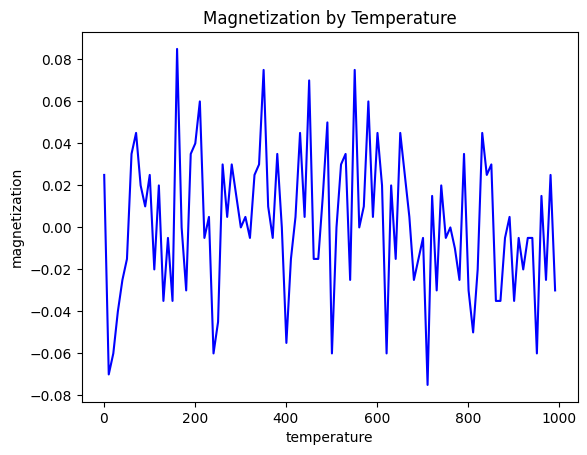

In [100]:
# plotting
plt.title("Magnetization by Temperature")
plt.xlabel("temperature")
temps = np.arange(1, 1000, 10)
plt.ylabel("magnetization")
plt.plot(temps, magnetizations, color ="blue", label="Sample Line")
plt.show()

We were unable to find a phase transition temperature, but we do notice a general trend of the magnetization decreasing and approaching a specific range as the temperature increases.